In [1]:
import numpy as np
import os.path as osp

from general_tools.in_out.basics import create_dir
from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import center_pclouds_in_unit_sphere, pclouds_centered_and_half_sphere, pclouds_with_zero_mean_in_unit_sphere

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
n_pc_samples = 2048
cmp_in_sphere = True
voxel_resolution = 28
class_name = 'chair'

def identity(x):
    return x

# pc_normalizer = pclouds_with_zero_mean_in_unit_sphere
pc_normalizer = identity

In [4]:
is_lwgan = False
is_rgan = True

assert(np.logical_xor(is_lwgan, is_rgan))

if is_lwgan:
    epochs_to_check = np.hstack([np.array([1, 5, 10]), np.arange(100, 2001, 100)])
    gan_tag = 'l_wgan_gp'
elif is_rgan:
    epochs_to_check = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
    gan_tag = 'r_gan'

In [5]:
# Load Ground-Truth Train Data.
top_gt_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/gt_data/'
gt_train_file = osp.join(top_gt_dir, class_name + '_train.npz')
gt_train_data = np.load(gt_train_file)  
gt_train_data = pc_normalizer(gt_train_data[gt_train_data.keys()[0]])

# Load Ground-Truth Test Data.
gt_test_file = osp.join(top_gt_dir, class_name + '_test.npz')
gt_test_data = np.load(gt_test_file)  
gt_test_data = pc_normalizer(gt_test_data[gt_test_data.keys()[0]])

In [6]:
# Specify where to load synthetic data.
top_in_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/'

if is_lwgan:
    top_synthetic_dir = osp.join(top_in_dir, 'l_wgan_chair_disc_512_1024_emd_bneck_128/lam_10/')
    special_tag = 'chair_disc_512_1024_emd_bneck_128_lam_10'
elif is_rgan:
    top_synthetic_dir = osp.join(top_in_dir, 'r_gan/chair_mlp_disc_4_fc_gen_raw_gan_2048_pts/')    
    special_tag = 'chair_mlp_disc_4_fc_gen_raw_gan_2048_pts'

In [7]:
top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/jsd'
create_dir(top_out_dir)
out_file = '_'.join([gan_tag, special_tag, pc_normalizer.__name__])
out_file = osp.join(top_out_dir, out_file + '.txt')

In [8]:
buf_size = 1 # flush each line
# fout = open(out_file, 'w', buf_size)
# fout.write('#Metric Epoch (Train-Test) Measurements\n')
print 'Saving measurements at: ' + out_file
epochs_to_check = [1000]
for epoch in epochs_to_check:
    sample_file = osp.join(top_synthetic_dir, 'epoch_%d.npz' % (epoch,) )
    sample_data = np.load(sample_file)
    sample_data = sample_data[sample_data.keys()[0]]
    sample_data = pc_normalizer(sample_data)
                    
    _, sample_var = entropy_of_occupancy_grid(sample_data, voxel_resolution, in_sphere=cmp_in_sphere)
    _, gt_train_var = entropy_of_occupancy_grid(gt_train_data, voxel_resolution, in_sphere=cmp_in_sphere)    
    _, gt_test_var = entropy_of_occupancy_grid(gt_test_data, voxel_resolution, in_sphere=cmp_in_sphere)
        
    jsd_train = jensen_shannon_divergence(gt_train_var, sample_var)
    jsd_test = jensen_shannon_divergence(gt_test_var, sample_var)
        
    log_data = 'JSD %d %f %f' % (epoch, jsd_train, jsd_test)
    print log_data
#     fout.write(log_data + '\n')

# fout.close()

Saving measurements at: /orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/jsd/r_gan_chair_mlp_disc_4_fc_gen_raw_gan_2048_pts_identity.txt


/orions4-zfs/projects/optas/Git_Repos/tf_lab/evaluate/generative_pc_nets.py:42: UserWarning: Point-clouds not unit sphere.
  warnings.warn('Point-clouds not unit sphere.')


JSD 1000 0.180842 0.182567


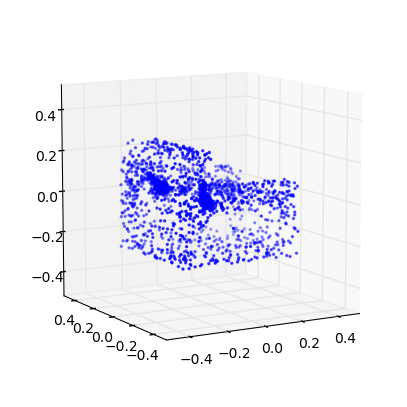

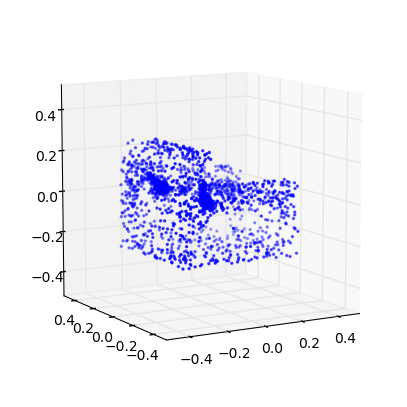

In [21]:
from geo_tool import Point_Cloud
Point_Cloud(sample_data[12]).plot()

In [ ]:
# OLD STUFF
# import warnings
# import os
# # Ignore TF related warnings.
# warnings.filterwarnings("ignore")
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# parser = argparse.ArgumentParser()
# parser.add_argument('--sample_dir', type=str, default = '', help='Directory of point-cloud samples.', required=True)
# parser.add_argument('--ref', type=str, default = '', help='Path to reference point-cloud.', required=True)
# parser.add_argument('--out_file', type=str, help='Save results in this file.', required=True)
# parser.add_argument('--epochs', type=list, default = [1, 3, 10, 30, 100, 300, 400, 500], help='Epochs to evaluate.')
# opt = parser.parse_args()